In [1]:
import torch
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold

# model architecture
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout_rate=0.2):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            #nn.BatchNorm1d(dim),
            nn.ReLU(),
            #nn.Dropout(dropout_rate),
            nn.Linear(dim, dim),
            #nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual  # Skip connection
        return self.relu(out)

class MLPRegressor(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=128, num_layers=3, output_dim=2, dropout_rate=0.2):
        super(MLPRegressor, self).__init__()
        
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            #nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            #nn.Dropout(dropout_rate)
        )
        
        self.residual_layers = nn.ModuleList([
            ResidualBlock(hidden_dim, dropout_rate) 
            for _ in range(num_layers - 1)
        ])
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.input_layer(x)
        for layer in self.residual_layers:
            x = layer(x)
        return self.output_layer(x)


In [2]:
def load_models(results_dir="Results"):
    # Get the most recent run directory
    run_dirs = [d for d in os.listdir(results_dir) if d.startswith("run_")]
    run_dirs.sort()
    selected_run = run_dirs[-3]
    run_path = os.path.join(results_dir, selected_run)
    
    print(f"Loading from directory: {run_path}")
    
    # Load metrics file to get feature names
    with open(os.path.join(run_path, "metrics.json"), 'r') as f:
        metrics = json.load(f)
    
    # Load models
    models = []
    models_dir = os.path.join(run_path, "models")
    for model_file in sorted(os.listdir(models_dir)):
        model = MLPRegressor(
            input_dim=len(metrics['input_features']),
            hidden_dim=1024,
            num_layers=128,
            output_dim=len(metrics['target_variables'])
        )
        model.load_state_dict(torch.load(os.path.join(models_dir, model_file)))
        model.eval()
        models.append(model)
    
    return models, metrics

def calculate_feature_importance(model, X, y, train_idx, val_idx, n_repeats=100):
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Split the data
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]
    
    # Create and fit scalers on training data
    scaler = StandardScaler()
    scaler_y = StandardScaler()
    
    # Fit on training data
    scaler.fit(X_train)
    scaler_y.fit(y_train)
    
    # Transform validation data for importance calculation
    X_scaled = scaler.transform(X_val)
    y_scaled = scaler_y.transform(y_val)
    
    # Convert to tensor
    X_tensor = torch.FloatTensor(X_scaled).to(device)
    y_tensor = torch.FloatTensor(y_scaled).to(device)
    
    # Calculate baseline score
    with torch.no_grad():
        baseline_pred = model(X_tensor)
        baseline_score = torch.mean((baseline_pred - y_tensor) ** 2).item()
    
    # Calculate importance for each feature
    importance = np.zeros((X.shape[1], n_repeats))
    
    for feature_idx in range(X.shape[1]):
        print(f"  Processing feature {input_cols[feature_idx]} ({feature_idx + 1}/{X.shape[1]})")
        for repeat in range(n_repeats):
            # Create permuted data
            X_permuted = X_scaled.copy()
            perm_idx = np.random.permutation(len(X_permuted))
            X_permuted[:, feature_idx] = X_permuted[perm_idx, feature_idx]
            
            # Convert to tensor
            X_perm_tensor = torch.FloatTensor(X_permuted).to(device)
            
            # Calculate permuted score
            with torch.no_grad():
                perm_pred = model(X_perm_tensor)
                perm_score = torch.mean((perm_pred - y_tensor) ** 2).item()
            
            # Calculate importance
            importance[feature_idx, repeat] = perm_score - baseline_score
    
    return importance.mean(axis=1)

In [3]:
# Load data
print("Loading data...")
data = pd.read_csv('processed_data.csv')
input_cols = ['Z', 'Wall', 'Overhang', 'NoLines', 'Power', 
                'd_edge_right', 'd_edge_left', 'd_over_left', 
                'd_over_right', 'd_col', 'd_over_z']
target_cols = ['meanLineIntensity', 'meanNumPixels15']

X = data[input_cols].values
y = data[target_cols].values

# Set up K-Fold cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Load models
print("Loading models...")
models, metrics = load_models()


Loading data...
Loading models...
Loading from directory: Results/run_20241116_141947


In [4]:
# Calculate importance for each fold
all_importance = []
for fold_idx, ((train_idx, val_idx), model) in enumerate(zip(kf.split(X), models)):
    print(f"Calculating importance for fold {fold_idx + 1}...")
    importance = calculate_feature_importance(model, X, y, train_idx, val_idx)
    all_importance.append(importance)
    
    # Save intermediate results after each fold
    mean_importance = np.mean(all_importance, axis=0)
    std_importance = np.std(all_importance, axis=0) if len(all_importance) > 1 else np.zeros_like(mean_importance)
    
    temp_df = pd.DataFrame({
        'Feature': input_cols,
        'Importance': mean_importance,
        'Std': std_importance
    })
    temp_df = temp_df.sort_values('Importance', ascending=False)
    print(f"\nIntermediate results after fold {fold_idx + 1}:")
    print(temp_df.to_string(index=False))


Calculating importance for fold 1...
  Processing feature Z (1/11)
  Processing feature Wall (2/11)
  Processing feature Overhang (3/11)
  Processing feature NoLines (4/11)
  Processing feature Power (5/11)
  Processing feature d_edge_right (6/11)
  Processing feature d_edge_left (7/11)
  Processing feature d_over_left (8/11)
  Processing feature d_over_right (9/11)
  Processing feature d_col (10/11)
  Processing feature d_over_z (11/11)

Intermediate results after fold 1:
     Feature  Importance  Std
           Z    0.959654  0.0
 d_edge_left    0.397478  0.0
d_edge_right    0.321664  0.0
 d_over_left    0.301527  0.0
     NoLines    0.238393  0.0
        Wall    0.171459  0.0
d_over_right    0.149354  0.0
    d_over_z    0.063298  0.0
       d_col    0.060159  0.0
    Overhang    0.028494  0.0
       Power    0.000000  0.0
Calculating importance for fold 2...
  Processing feature Z (1/11)
  Processing feature Wall (2/11)
  Processing feature Overhang (3/11)
  Processing feature NoLi


Final Feature Importance Rankings:
     Feature  Importance      Std
           Z    0.930601 0.078014
 d_edge_left    0.402542 0.013713
d_edge_right    0.351490 0.036340
     NoLines    0.325723 0.055866
 d_over_left    0.306918 0.028979
d_over_right    0.198134 0.034052
        Wall    0.138020 0.044955
    d_over_z    0.099594 0.020860
       d_col    0.087696 0.016080
    Overhang    0.029272 0.008327
       Power    0.000000 0.000000

Results saved to feature_importance_results.csv


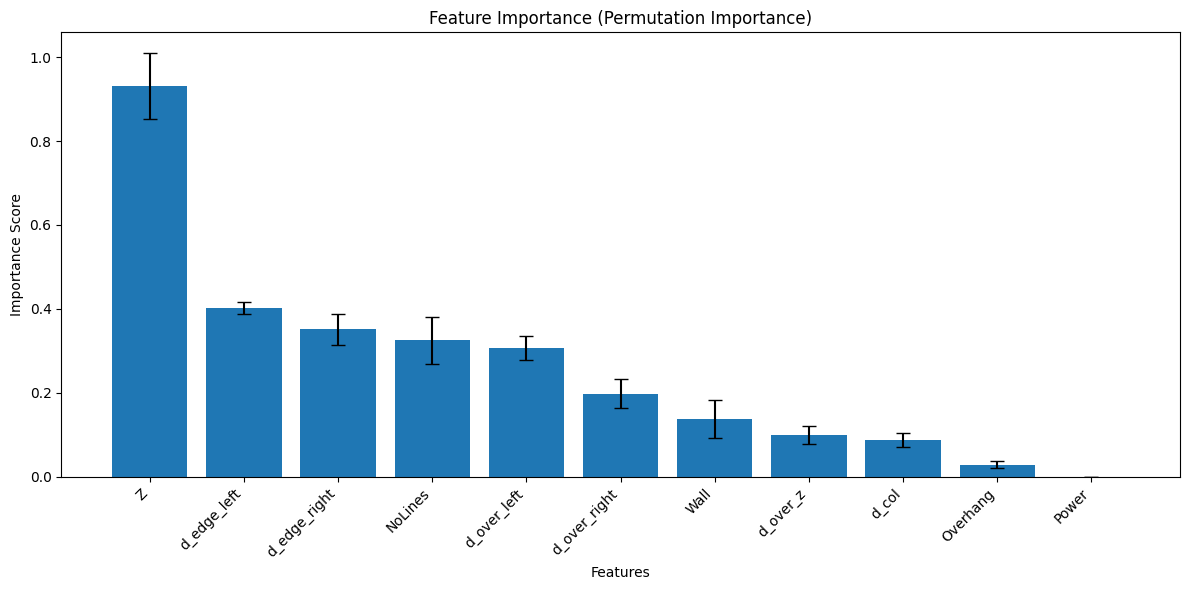

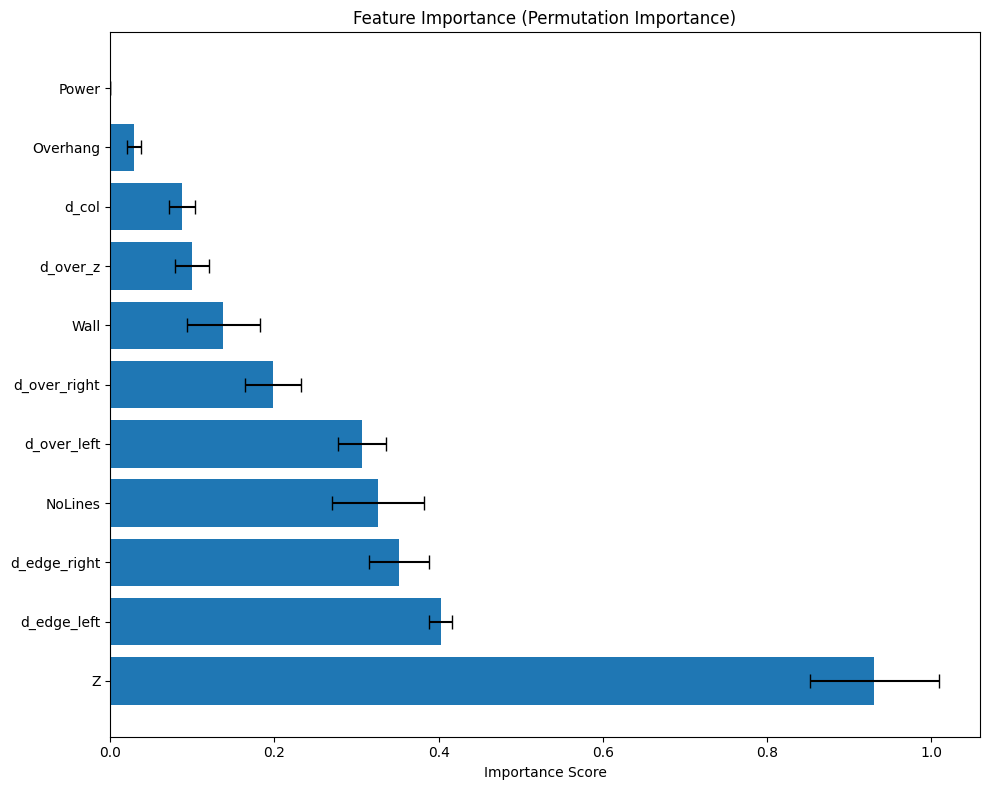

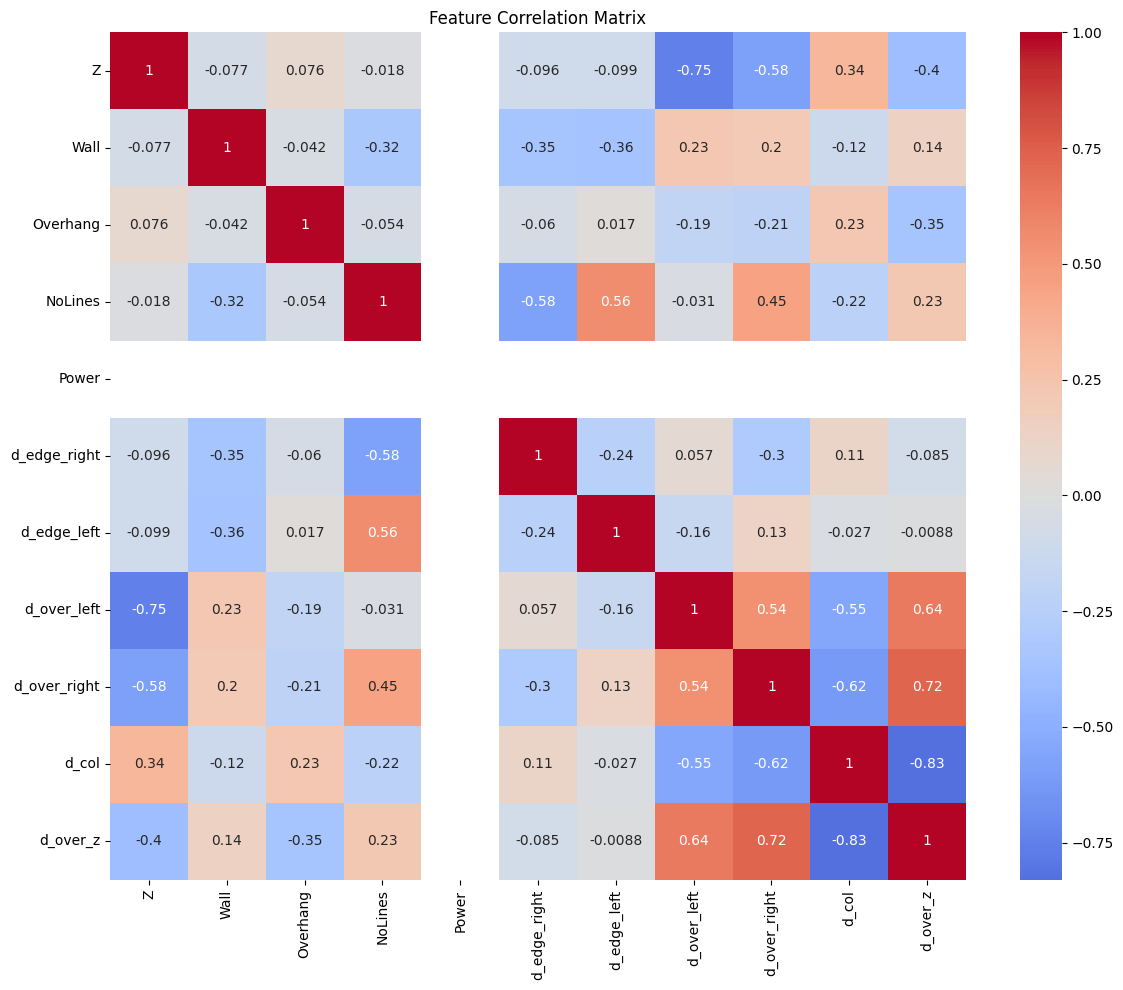


Summary of Feature Importance:
--------------------------------------------------
Most important feature: Z (score: 0.930601)
Least important feature: Power (score: 0.000000)

Feature ranking by importance:
1. Z: 0.930601 ± 0.078014
7. d_edge_left: 0.402542 ± 0.013713
6. d_edge_right: 0.351490 ± 0.036340
4. NoLines: 0.325723 ± 0.055866
8. d_over_left: 0.306918 ± 0.028979
9. d_over_right: 0.198134 ± 0.034052
2. Wall: 0.138020 ± 0.044955
11. d_over_z: 0.099594 ± 0.020860
10. d_col: 0.087696 ± 0.016080
3. Overhang: 0.029272 ± 0.008327
5. Power: 0.000000 ± 0.000000

Feature Statistics:
                 Z         Wall     Overhang      NoLines   Power  d_edge_right  d_edge_left  d_over_left  d_over_right        d_col     d_over_z
count  1812.000000  1812.000000  1812.000000  1812.000000  1812.0   1812.000000  1812.000000  1812.000000   1812.000000  1812.000000  1812.000000
mean      0.945502     0.115894     0.013245    35.152870   180.0      1.095557     1.098565     2.280353      2.53388

In [5]:
# Calculate mean and std from all_importance
mean_importance = np.mean(all_importance, axis=0)
std_importance = np.std(all_importance, axis=0)

# Create importance DataFrame
importance_df = pd.DataFrame({
    'Feature': input_cols,
    'Importance': mean_importance,
    'Std': std_importance
})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print final numerical results
print("\nFinal Feature Importance Rankings:")
print(importance_df.to_string(index=False))

# Save results to CSV
results_file = "feature_importance_results.csv"
importance_df.to_csv(results_file, index=False)
print(f"\nResults saved to {results_file}")

# Create bar plot using plt instead of seaborn
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], 
        yerr=importance_df['Std'], capsize=5)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.title('Feature Importance (Permutation Importance)')
plt.tight_layout()
plt.show()

# Create horizontal bar plot for better readability
plt.figure(figsize=(10, 8))
y_pos = np.arange(len(importance_df['Feature']))
plt.barh(y_pos, importance_df['Importance'], 
         xerr=importance_df['Std'], capsize=5)
plt.yticks(y_pos, importance_df['Feature'])
plt.xlabel('Importance Score')
plt.title('Feature Importance (Permutation Importance)')
plt.tight_layout()
plt.show()

# Create a correlation heatmap for the features
plt.figure(figsize=(12, 10))
correlation_matrix = data[input_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary of Feature Importance:")
print("-" * 50)
print(f"Most important feature: {importance_df['Feature'].iloc[0]} (score: {importance_df['Importance'].iloc[0]:.6f})")
print(f"Least important feature: {importance_df['Feature'].iloc[-1]} (score: {importance_df['Importance'].iloc[-1]:.6f})")
print("\nFeature ranking by importance:")
for i, row in importance_df.iterrows():
    print(f"{i+1}. {row['Feature']}: {row['Importance']:.6f} ± {row['Std']:.6f}")

# Print feature statistics
print("\nFeature Statistics:")
print(data[input_cols].describe().to_string())